In [2]:
import zipfile
z = zipfile.ZipFile("archive.zip")
z.extractall()

In [1]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [4]:
labels = ['PNEUMONIA','NORMAL']
img_size = 128

def get_data(data_dir):
    images = []
    targets = []
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                
                images.append(resized_arr)
                targets.append(class_num)
            except Exception as e:
                print(e)
    
    return np.array(images), np.array(targets)


In [5]:
X_train, y_train = get_data("chest_xray/chest_xray/train")
X_test,  y_test  = get_data("chest_xray/chest_xray/test")
X_val,   y_val   = get_data("chest_xray/chest_xray/val")

print(X_train.shape)  # expected: (N_train, 128, 128)
print(y_train.shape)  # expected: (N_train,)


(5216, 128, 128)
(5216,)


In [6]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
penomina_dir = "chest_xray/train/PNEUMONIA"

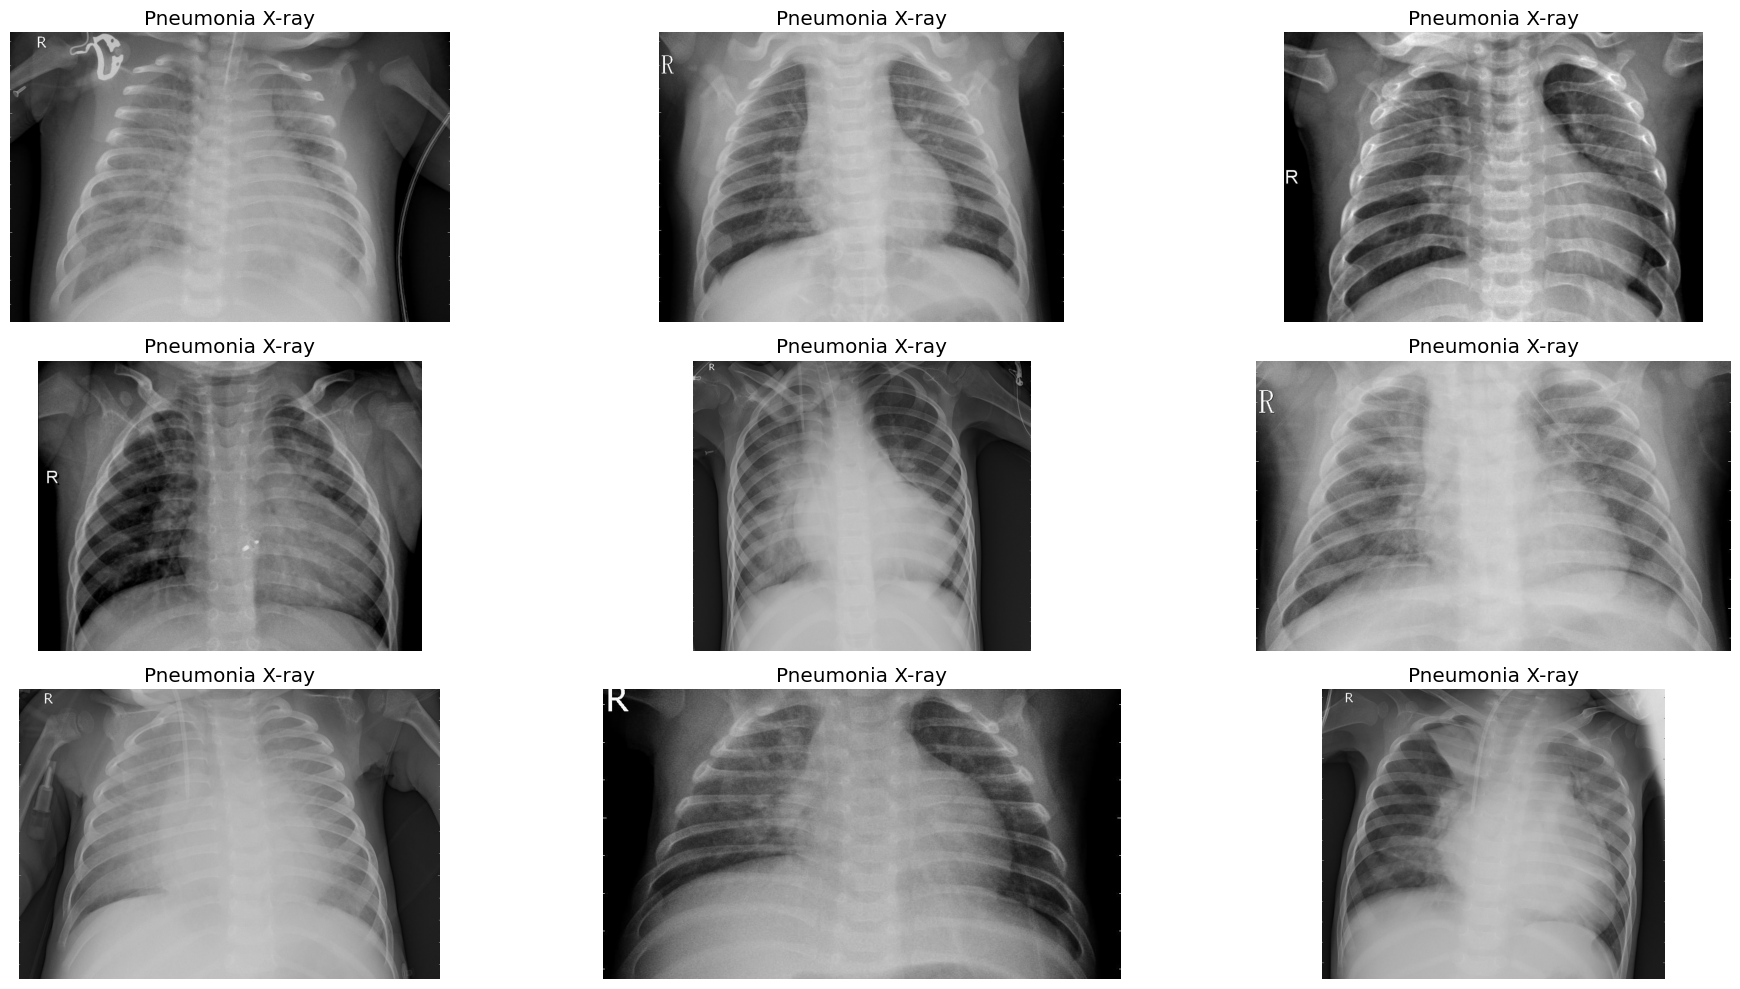

In [7]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(penomina_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

In [8]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

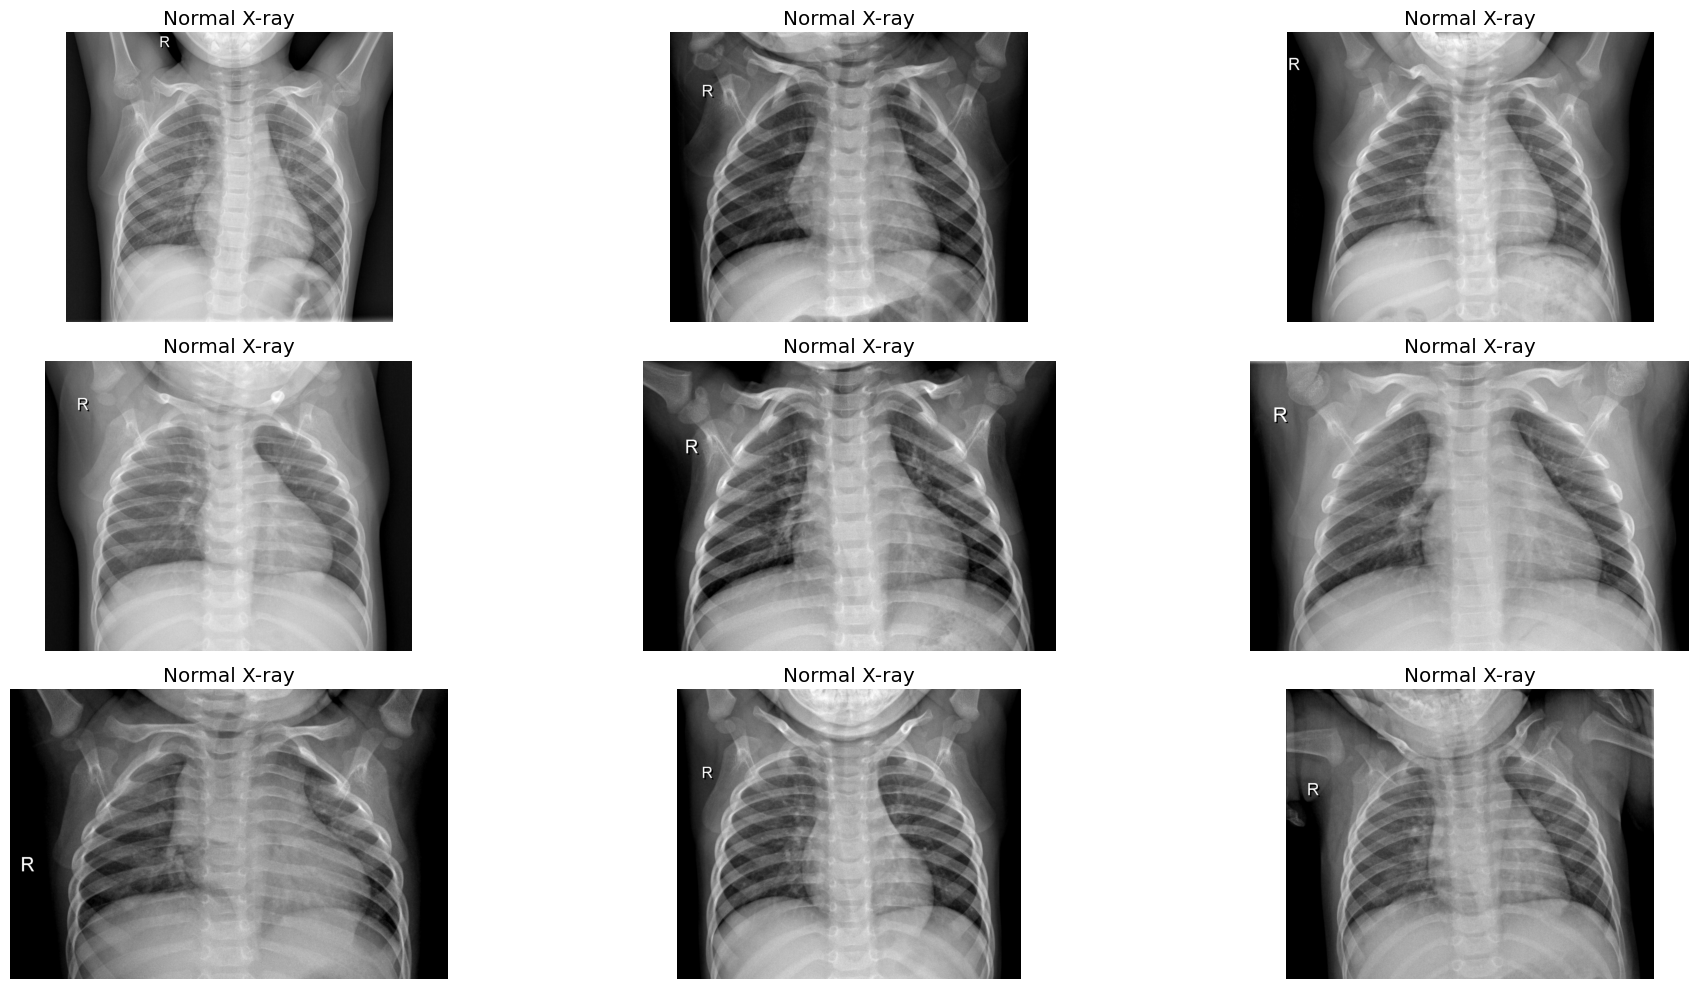

In [9]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

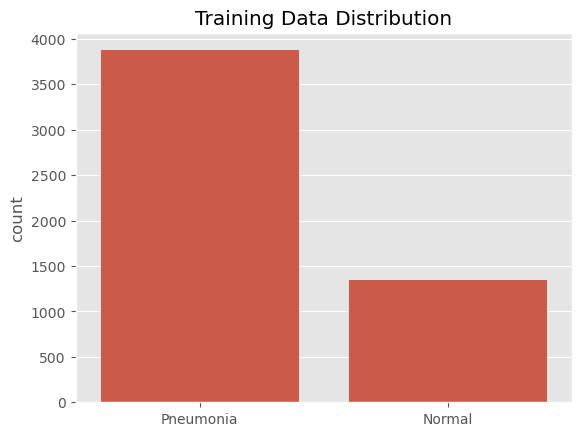

In [11]:
import seaborn as sns

listx = []

for lbl in y_train:
    if lbl == 0:
        listx.append("Pneumonia")
    else:
        listx.append("Normal")

sns.countplot(x=listx)
plt.title("Training Data Distribution")
plt.show()


In [ ]:
# Data Augmentation & Resizing

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
train_datagen = ImageDataGenerator(rescale = 1. / 255, 
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [3]:
train_generator = train_datagen.flow_from_directory("chest_xray/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("chest_xray/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [4]:
class_labels = train_generator.class_indices

In [5]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [6]:
class_name = {value:key for (key, value) in class_labels.items()}

In [7]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [ ]:
# VGG19 CNN Architecture

In [8]:
base_model = VGG19(input_shape = (128,128,3),
                     include_top = False,
                     weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.inputs, output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [10]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

filepath = "model.h5"

es = EarlyStopping(
    monitor="val_loss",
    patience=4,
    verbose=1,
    mode="min"
)

cp = ModelCheckpoint(
    filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch"
)

lrr = ReduceLROnPlateau(
    monitor="val_accuracy",
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.0001
)

# Updated: Removed deprecated decay + set momentum to valid float
sgd = SGD(
    learning_rate=0.0001,
    momentum=0.9,
    nesterov=True
)

model_01.compile(
    loss="categorical_crossentropy",
    optimizer=sgd,
    metrics=["accuracy"]
)


In [11]:
history_01 = model_01.fit(train_generator, 
            steps_per_epoch=50,
            epochs=1, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6381 - loss: 0.7263

50/50 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.7131 - loss: 0.5971 - val_accuracy: 0.5000 - val_loss: 0.7242 - learning_rate: 1.0000e-04


In [13]:
model_01.save(filepath = "model_weights/vgg19_model_01.h5", overwrite=True)

In [14]:
test_generator = test_datagen.flow_from_directory("chest_xray/chest_xray/test",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 624 images belonging to 2 classes.


In [15]:
model_01.load_weights("model_weights/vgg19_model_01.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.7242
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.6250 - loss: 0.6022


In [17]:
print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg_test_eval_01[1]}")

Validation Loss: 0.7241554260253906
Validation Accuarcy: 0.5
Test Loss: 0.6021820306777954
Test Accuarcy: 0.625


In [ ]:
# Increamental unfreezing & fine tuning

In [18]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights("model_weights/vgg19_model_01.h5")

set_trainable = False
for layer in base_model.layers:
    if layer.name in [ 'block5_conv3','block5_conv4']:
        set_trainable=True
    if set_trainable:
        set_trainable=True
    else:
        set_trainable=False
print(model_02.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
base_model_layer_names

['input_layer_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [21]:
from tensorflow.keras.optimizers import SGD

# Updated optimizer: removed deprecated `decay` + momentum must be float
sgd = SGD(
    learning_rate=0.0001,
    momentum=0.9,     # use 0.0 if you want no momentum, but must be float
    nesterov=True
)

model_02.compile(
    loss="categorical_crossentropy",
    optimizer=sgd,
    metrics=["accuracy"]
)


In [22]:
history_02 = model_02.fit(train_generator, 
            steps_per_epoch=10,
            epochs=1, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7668 - loss: 0.4815 

10/10 ━━━━━━━━━━━━━━━━━━━━ 251s 22s/step - accuracy: 0.7781 - loss: 0.4779 - val_accuracy: 0.5000 - val_loss: 0.7037 - learning_rate: 1.0000e-04


In [23]:
model_02.save(filepath = "model_weights/vgg19_model_02.h5", overwrite=True)

In [24]:
model_02.load_weights("model_weights/vgg19_model_02.h5")

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_02[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_02[1]}")
print(f"Test Loss: {vgg_test_eval_02[0]}")
print(f"Test Accuarcy: {vgg_test_eval_02[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.7037
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.6298 - loss: 0.5794
Validation Loss: 0.703652024269104
Validation Accuarcy: 0.5
Test Loss: 0.5793777108192444
Test Accuarcy: 0.629807710647583


In [ ]:
# Unfreezing and fine tuning the entire network

In [25]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights("model_weights/vgg19_model_01.h5")

print(model_03.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [3]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(
    learning_rate=0.0001,
    momentum=0.9,  # must be a float between 0 and 1
    nesterov=True
)  # removed deprecated `decay`

model_03.compile(
    loss="categorical_crossentropy",
    optimizer=sgd,
    metrics=["accuracy"]
)


NameError: name 'model_03' is not defined

In [30]:
history_03 = model_03.fit(train_generator, 
            steps_per_epoch=100,
            epochs=1, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7910 - loss: 0.4404 

100/100 ━━━━━━━━━━━━━━━━━━━━ 1034s 10s/step - accuracy: 0.8225 - loss: 0.3795 - val_accuracy: 0.6875 - val_loss: 0.4846 - learning_rate: 1.0000e-04


In [31]:
model_03.save(filepath = "model_weights/vgg19_model_03.h5", overwrite=True)

In [1]:
model_03.load_weights("model_weights/vgg19_model_03.h5")

vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_03[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_03[1]}")
print(f"Test Loss: {vgg_test_eval_03[0]}")
print(f"Test Accuarcy: {vgg_test_eval_03[1]}")

NameError: name 'model_03' is not defined

In [2]:
x

NameError: name 'x' is not defined

In [4]:
import zipfile
import os

# 1. Name of the file you pasted (Check if it is 'archive.zip' or something else)
zip_file_name = "archivenew.zip"  

# 2. Extract it
print(f"Extracting {zip_file_name}...")
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(".")

print("✅ Extraction Complete!")

# 3. Verify the folder name
# You should see 'COVID-19_Radiography_Dataset' in the list below
print("Files in directory:", os.listdir("."))

Extracting archivenew.zip...
✅ Extraction Complete!
Files in directory: ['.ipynb_checkpoints', 'archive.zip', 'archivenew.zip', 'chest_xray', 'COVID-19_Radiography_Dataset', 'Flask Application', 'model.h5', 'model_weights', 'pre.ipynb', 'Untitled.ipynb', 'untitled.py']
